# Equivalent Layer technique for estimating magnetization direction of a magnetized source

#### Importing libraries

In [1]:
% matplotlib inline 

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import datetime
import timeit
from scipy.optimize import nnls
from fatiando.gridder import regular
from fatiando.utils import ang2vec, vec2ang
from fatiando.mesher import Sphere, PointGrid,Prism
from fatiando.gravmag import sphere,prism
from fatiando.constants import CM, T2NT, G, SI2MGAL

/home/andre/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [3]:
notebook_name = 'airborne_EQL_magdirection_IM.ipynb'

### Gray background figures

In [4]:
plt.style.use('grayscale')

#### Importing auxiliary functions

In [5]:
dir_modules = '../../mypackage'
sys.path.append(dir_modules)

In [6]:
import auxiliary_functions as fc

#### Loading properties of the model

In [7]:
with open('data/model_sphere_induced.pickle') as f:
        model_sphere_induced = pickle.load(f)

#### Loading properties grid

In [8]:
with open('data/airborne_survey.pickle') as f:
        airborne = pickle.load(f)

#### Loading data

In [9]:
with open('data/data_set.pickle') as f:
        data = pickle.load(f)

#### Open a dictionary

In [10]:
dir_sphere = dict()

### Saving files

In [11]:
saved_files = []

## Observation area

In [12]:
print 'Area limits: \n x_max = %.1f m \n x_min = %.1f m \n y_max = %.1f m \n y_min = %.1f m' % (airborne['area'][1], 
                                                                                                airborne['area'][0],
                                                                                                airborne['area'][3],
                                                                                                airborne['area'][2])

Area limits: 
 x_max = 5000.0 m 
 x_min = -5000.0 m 
 y_max = 5000.0 m 
 y_min = -5000.0 m


### Airborne survey information

In [13]:
print 'Shape : (%.0f,%.0f)'% airborne['shape'] 
print 'Number of data: %.1f' % airborne['N']
print 'dx: %.1f m' % airborne['dx']
print 'dy: %.1f m ' % airborne['dy']

Shape : (50,20)
Number of data: 1000.0
dx: 204.1 m
dy: 526.3 m 


## Properties of the model

### Main field

In [14]:
inc_gf,dec_gf = model_sphere_induced['main_field']

In [15]:
print'Main field inclination: %.1f degree' % inc_gf
print'Main field declination: %.1f degree' % dec_gf

Main field inclination: 40.0 degree
Main field declination: 45.0 degree


### Magnetization direction

In [16]:
print 'Intensity: %.1f A/m' % model_sphere_induced['m']
print 'Inclination: %.1f degree' % model_sphere_induced['inc']
print 'Declination: %.1f degree' % model_sphere_induced['dec']

Intensity: 15.0 A/m
Inclination: 40.0 degree
Declination: 45.0 degree


In [17]:
inc_I,dec_I = model_sphere_induced['inc'],model_sphere_induced['dec']

## Generating the layer with my function 

In [18]:
h = 550.

#### Generating a layer

In [19]:
shape_layer = (airborne['shape'][0],airborne['shape'][1])

In [20]:
xs,ys,zs = regular(airborne['area'],shape_layer,h)

## Non-negative Least Squares Method for estimating a positive layer

In [21]:
G = fc.sensitivity_mag(airborne['x'],airborne['y'],airborne['z'],
                       xs,ys,zs,inc_gf,dec_gf,inc_I,dec_I)

In [22]:
start_time = timeit.default_timer()

In [23]:
m_pos,_ = nnls(G,data['tfa_obs_sphere_IM_airb'])

In [24]:
elapsed = timeit.default_timer() - start_time

In [25]:
print elapsed

2.13860607147


In [26]:
tf_pred_pos = fc.tfa_layer(airborne['x'],airborne['y'],airborne['z'],
                           xs,ys,zs,inc_gf,dec_gf,m_pos,inc_I,dec_I)

### Calculating residual

In [27]:
r_pos = data['tfa_obs_sphere_IM_airb'] - tf_pred_pos

#### Parameters for normalized histogram

In [28]:
r_norm,r_mean,r_std = fc.residual(data['tfa_obs_sphere_IM_airb'],tf_pred_pos)

In [29]:
print r_mean

-0.31933980900707093


## Comparison between the Model and the Layer with posivity

/home/andre/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/andre/anaconda2/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


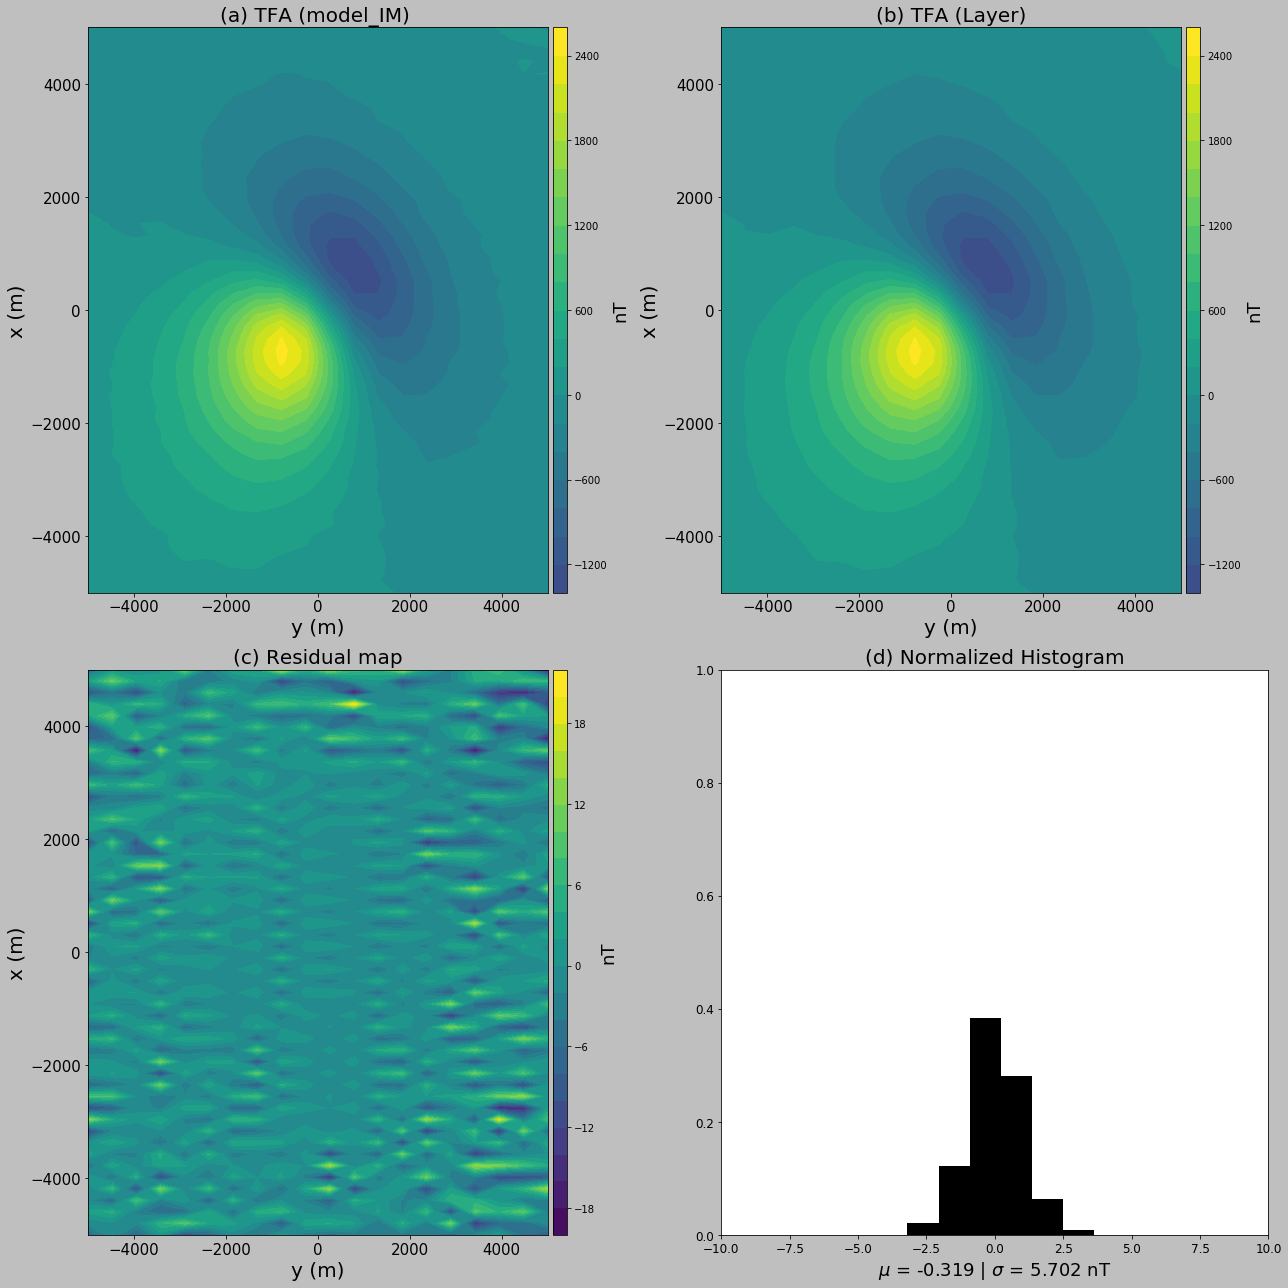

In [30]:
title_font = 20
bottom_font = 18
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(18,18), tight_layout=True)

ranges = saturation_factor*np.abs([data['tfa_obs_sphere_IM_airb'].max(), 
                                   data['tfa_obs_sphere_IM_airb'].min(),
                                   tf_pred_pos.max(), tf_pred_pos.min()]).max()

r_ranges = saturation_factor*np.abs([r_pos.max(), r_pos.min()]).max()


plt.subplot(2,2,1)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']), 
             data['tfa_obs_sphere_IM_airb'].reshape(airborne['shape']),
             20, cmap='viridis',vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font) 
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(a) TFA (model_IM) ', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,2)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']),
             tf_pred_pos.reshape(airborne['shape']),
             20, cmap='viridis',  vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(b) TFA (Layer)', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=15)

plt.subplot(2,2,3)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']),
             r_pos.reshape(airborne['shape']), 
             20, cmap='viridis',  vmin=-r_ranges, vmax=r_ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(c) Residual map', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=15)


plt.subplot(2,2,4)
plt.xlabel('$\mu$ = %.3f | $\sigma$ = %.3f nT' % (r_mean, r_std),
           fontsize = bottom_font)
nbins = int((np.max(r_norm - np.min(r_norm))))
plt.hist(r_norm,bins=nbins,normed=True)
plt.ylim(0.,1.)
plt.xlim(-10., 10.)
plt.title('(d) Normalized Histogram',fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

file_name = 'figs/airborne/noisy_data_fitting_NNLS_magIM'
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')

plt.show()

### Magnetic moment within the Layer with positivity constraint

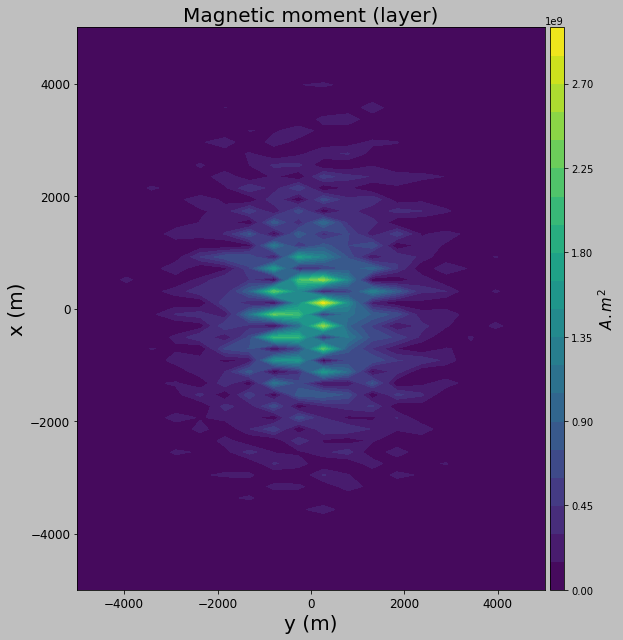

In [31]:
title_font = 20
bottom_font = 18
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(9,9), tight_layout=True)

plt.contourf(ys.reshape(shape_layer),xs.reshape(shape_layer), 
             m_pos.reshape(shape_layer),20, cmap='viridis')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('$A.m^2$',size=15)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('Magnetic moment (layer)', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

file_name = 'figs/airborne/noisy_magnetic_moment_positive_NNLS_magIM'
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')

plt.show()

### Levenberg-Marquardt with NNLS for positive magnetic moments

In [32]:
i_pos = 1500

In [33]:
it_max = 30

In [34]:
it_marq = 15

In [35]:
lamb = 10.
dlamb = 100.

In [36]:
eps_e = 1e-4
eps_i = 1e-4

In [37]:
m_LM,inc_est,dec_est,phi,imax,pest,incs,decs = fc.levenberg_marquardt_NNLS(
    data['tfa_obs_sphere_IM_airb'],airborne['x'],airborne['y'],
    airborne['z'],xs,ys,zs,inc_gf,dec_gf,0.,0.,lamb,dlamb,i_pos,it_max,
    it_marq,eps_e,eps_i)

i = 0
1.0031301313684613e-09
7.379271438201441 2.556229242294455
0.5208021407151956
i = 1
9.334056866192594e-05
11.469724439201574 3.917961914176275
0.31241596236355257
i = 2
9.012760131971028e-05
14.579804007697064 5.177262470971149
0.2433343629040984
i = 3
7.097850416314165e-05
17.03699902562489 6.317278825737563
0.1937062247124816
i = 4
5.367140795223006e-05
19.0437270561124 7.35426884014821
0.15883414718003913
i = 5
4.4326198537947423e-05
20.740637273878708 8.350243860455521
0.13809284004968075
i = 6
3.596065396214826e-05
22.195824621837737 9.29712342830064
0.12158037945609709
i = 7
2.8368589499403312e-05
23.45407877422056 10.189020049022064
0.10707055916630336
i = 8
2.2423508549773194e-05
24.554875052995865 11.028237997935765
0.09524014605559707
i = 9
1.7857720616466057e-05
25.52750874120803 11.819740949502544
0.08546692070947952
i = 10
1.5115807972883764e-05
26.397236562263377 12.58672027312813
0.07878409310430094
i = 11
1.2756035260400744e-05
27.179001172093855 13.32733995526822

3.346803628719409e-09
37.945640263425226 36.890263751364245
0.005569913313327424
i = 96
3.1027694969841966e-09
37.96171214045488 36.987197788438124
0.005404402759827717
i = 97
2.8762704461774145e-09
37.97744279925336 37.082215311288124
0.005241356625276353
i = 98
2.6662780236414326e-09
37.99284749136468 37.17535054766123
0.005081732798066514
i = 99
2.4715151326985574e-09
38.00794118422432 37.266635860474196
0.004925427117602614
i = 100
2.290939978419475e-09
38.02273793928828 37.35610404965245
0.00477254005160154
i = 101
2.123580760502754e-09
38.03725090895553 37.44378835748259
0.004623162902010882
i = 102
1.9684506585971594e-09
38.051492674726596 37.52972125928342
0.004477271534826282
i = 103
1.8244160942782517e-09
38.06547576785906 37.61393062771056
0.004334484153849564
i = 104
1.6907865486410492e-09
38.079210908743754 37.696446739535645
0.00419503070619263
i = 105
1.5669932174258839e-09
38.09270875188429 37.77730153044974
0.004059126131178832
i = 106
1.4523240893471709e-09
38.1059793

3.1441557426042616e-11
38.82538325794269 41.53928882323151
0.0006815314667226423
i = 189
3.054749797540042e-11
38.83148030631442 41.56785535335651
0.0006727463701963949
i = 190
2.9683019204951186e-11
38.83752745075726 41.596226838510425
0.0006640975063638453
i = 191
2.8845058444120198e-11
38.84352520239115 41.62440532127971
0.000655582329001184
i = 192
2.803398010742675e-11
38.849474064565854 41.65239281321397
0.0006471983481139359
i = 193
2.7248724756965373e-11
38.855374533043616 41.68019129542366
0.000638943128527629
i = 194
2.648557993924703e-11
38.86122706331875 41.707802522176415
0.0006308055248563759
i = 195
2.5745899244041742e-11
38.867032048529104 41.73522788491736
0.0006227686059895985
i = 196
2.5028186989522394e-11
38.87278996588581 41.76246929117569
0.0006148544463933261
i = 197
2.4330936927630663e-11
38.8785012856103 41.78952862000439
0.0006070607898314295
i = 198
2.3656310102933888e-11
38.88416647109326 41.81640772252135
0.0005993854291363194
i = 199
2.300299717421723e-11


3.2157126672283326e-12
39.224239511174396 43.55470704103535
0.00024047113199101978
i = 281
3.147795030823606e-12
39.22724255839418 43.571514065371716
0.00023805771111808652
i = 282
3.08023273471901e-12
39.23022476850587 43.58823655625653
0.0002356722932081708
i = 283
3.013899185717528e-12
39.23318629955101 43.604875102826
0.00023331449670251932
i = 284
2.948361224574993e-12
39.23612730822849 43.62143028818183
0.00023098394615712233
i = 285
2.8875473556991297e-12
39.23904794990975 43.637902689475396
0.00022868027213047968
i = 286
2.8231725936899188e-12
39.24194836867964 43.65429287911277
0.00022640299076064766
i = 287
2.764839397901958e-12
39.24482871978586 43.670601702605
0.000224158860111332
i = 288
2.707533275148407e-12
39.24768915916197 43.68682988170656
0.00022194454417494614
i = 289
2.647323257298373e-12
39.25052983722537 43.70297796650233
0.00021975549222730278
i = 290
2.5940439946871268e-12
39.253350903132876 43.719046501570965
0.00021759136619535813
i = 291
2.5393946024695663e-

4.851961638530593e-13
39.417391246280516 44.812723529691034
0.00010001197258311564
i = 373
9.892903332137708e-05
39.417391246280516 44.812723529691034
0.0


### Visualization of the convergence

In [38]:
phi = (np.array(phi)/airborne['x'].size)

<Figure size 648x648 with 0 Axes>

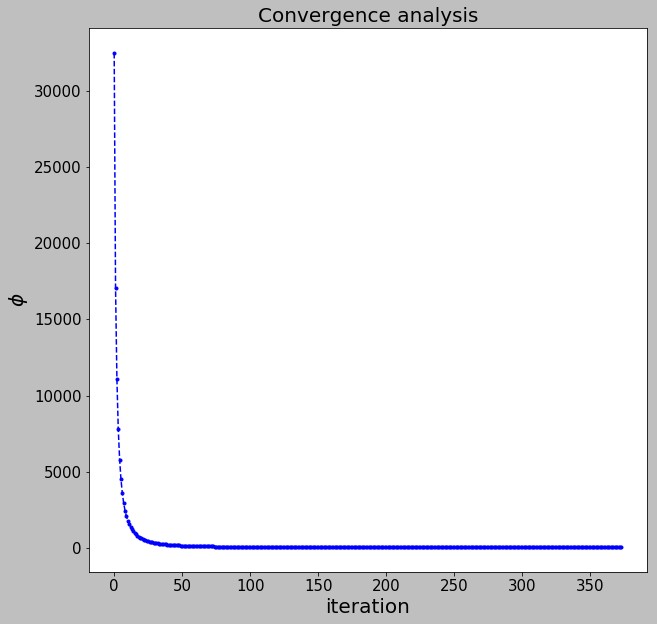

In [39]:
title_font = 20
bottom_font = 18
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(9,9), tight_layout=True)

plt.figure(figsize=(10, 10))
plt.plot(phi, 'b--')
plt.plot(phi, 'b.')

plt.title('Convergence analysis', fontsize=title_font)
plt.xlabel('iteration', fontsize = title_font)
plt.ylabel('$\phi$', fontsize = title_font)
plt.tick_params(axis='both', which='major', labelsize=15)

file_name = 'figs/airborne/convergence_LM_NNLS_magIM'
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')

plt.show()

### Estimated magnetization direction

In [40]:
print (inc_est,dec_est)

(39.417391246280516, 44.812723529691034)


In [41]:
print (inc_I,dec_I)

(40.0, 45.0)


### Comparison between observed data and predicted data

In [42]:
pred = fc.tfa_layer(airborne['x'],airborne['y'],airborne['z'],
                    xs,ys,zs,inc_gf,dec_gf,m_LM,inc_est,dec_est)

In [43]:
res = pred - data['tfa_obs_sphere_IM_airb']

In [44]:
r_norm,r_mean,r_std = fc.residual(data['tfa_obs_sphere_IM_airb'],pred)

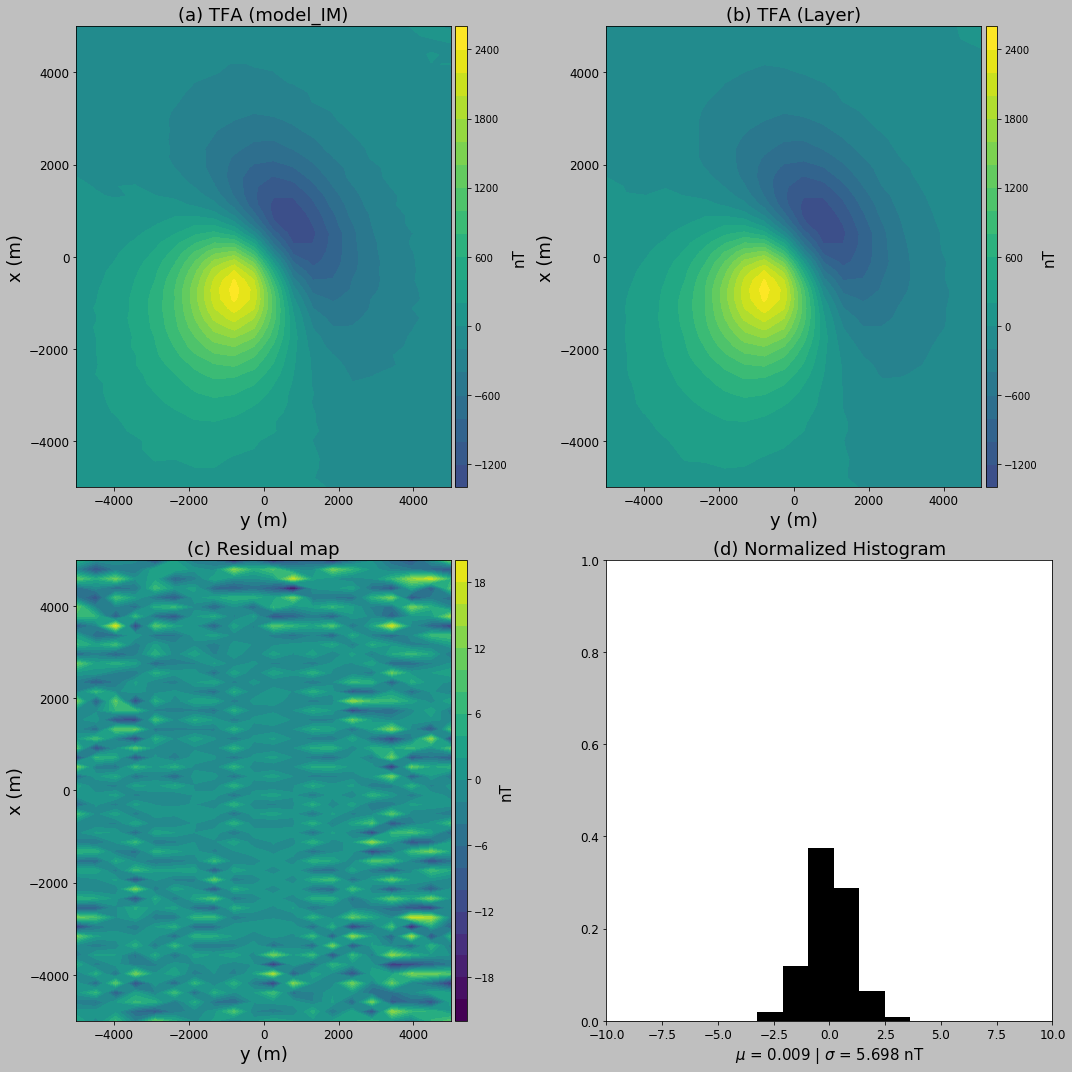

In [45]:
title_font = 18
bottom_font = 15
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(15,15), tight_layout=True)

ranges = saturation_factor*np.abs([data['tfa_obs_sphere_IM_airb'].max(), 
                                   data['tfa_obs_sphere_IM_airb'].min(),
                                   pred.max(), pred.min()]).max()
res_ranges = np.max(np.abs(res))

plt.subplot(2,2,1)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']), 
             data['tfa_obs_sphere_IM_airb'].reshape(airborne['shape']),
             20, cmap='viridis',vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(a) TFA (model_IM)',fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(2,2,2)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']),
             pred.reshape(airborne['shape']),
             20, cmap='viridis',  vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(b) TFA (Layer)', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(2,2,3)
plt.contourf(airborne['y'].reshape(airborne['shape']),
             airborne['x'].reshape(airborne['shape']),
             res.reshape(airborne['shape']), 
             20, cmap='viridis',  vmin=-res_ranges, vmax=res_ranges)
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('(c) Residual map', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)


plt.subplot(2,2,4)
plt.xlabel('$\mu$ = %.3f | $\sigma$ = %.3f nT' % (r_mean, r_std),
           fontsize = bottom_font)
nbins = int((np.max(r_norm - np.min(r_norm))))
plt.hist(r_norm,bins=nbins,normed=True)
plt.ylim(0.,1.)
plt.xlim(-10., 10.)
plt.title('(d) Normalized Histogram',fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

file_name = 'figs/airborne/data_fitting_LM_NNLS_magIM'
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')

plt.show()

### Estimated magnetic moment within the layer

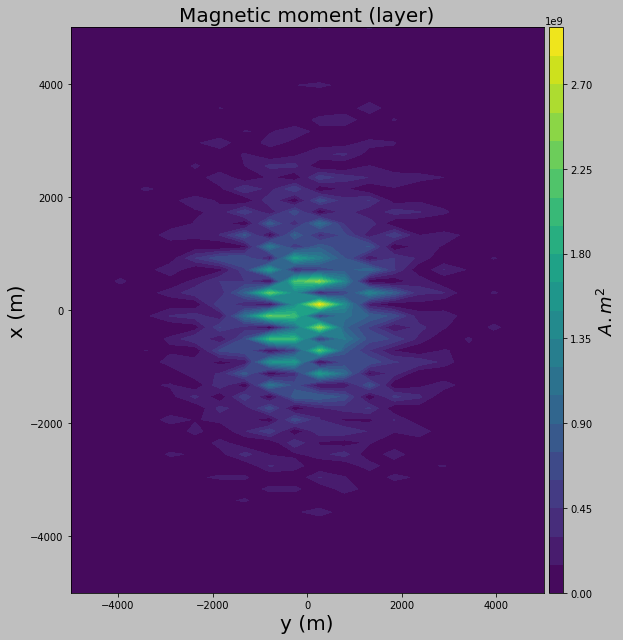

In [46]:
title_font = 20
bottom_font = 18
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(9,9), tight_layout=True)

plt.contourf(ys.reshape(shape_layer),xs.reshape(shape_layer), 
             m_LM.reshape(shape_layer), 20, cmap='viridis')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('$A.m^2$',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('Magnetic moment (layer)', fontsize=title_font)

file_name = 'figs/airborne/magnetic_moment_positive_LM_NNLS_magIM'
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')

plt.show()

### Reduction to the pole

In [47]:
G_rtp = fc.sensitivity_mag(airborne['x'],airborne['y'],airborne['z'],
                       xs,ys,zs,90.,0.,90.,0.)

In [48]:
tfa_rtp = np.dot(G_rtp,m_LM)

#### Visualization of a reduction to the pole

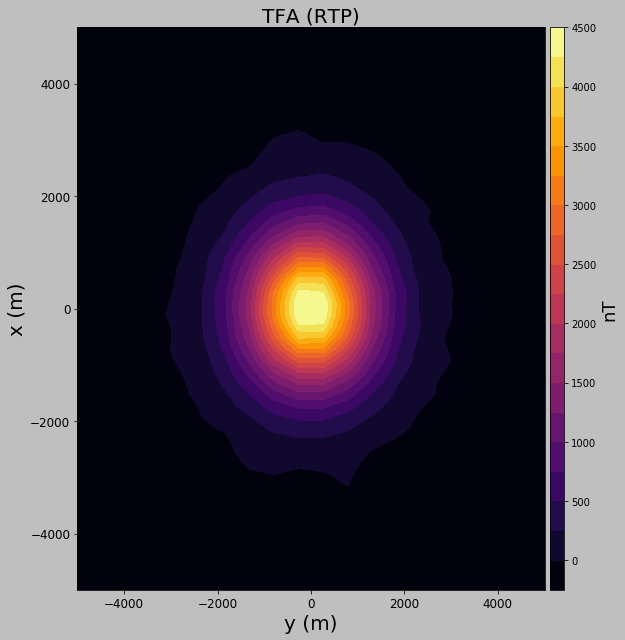

In [49]:
title_font = 20
bottom_font = 18
saturation_factor = 1.
plt.close('all')
plt.figure(figsize=(9,9), tight_layout=True)

plt.contourf(airborne['y'].reshape(airborne['shape']), 
             airborne['x'].reshape(airborne['shape']),
             tfa_rtp.reshape(airborne['shape']), 
             20, cmap='inferno')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('TFA (RTP)', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

file_name = 'figs/airborne/RTP_airborne_magIM'
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')

plt.show()

# Visualization of the RTP and Magnetic moment over the layer

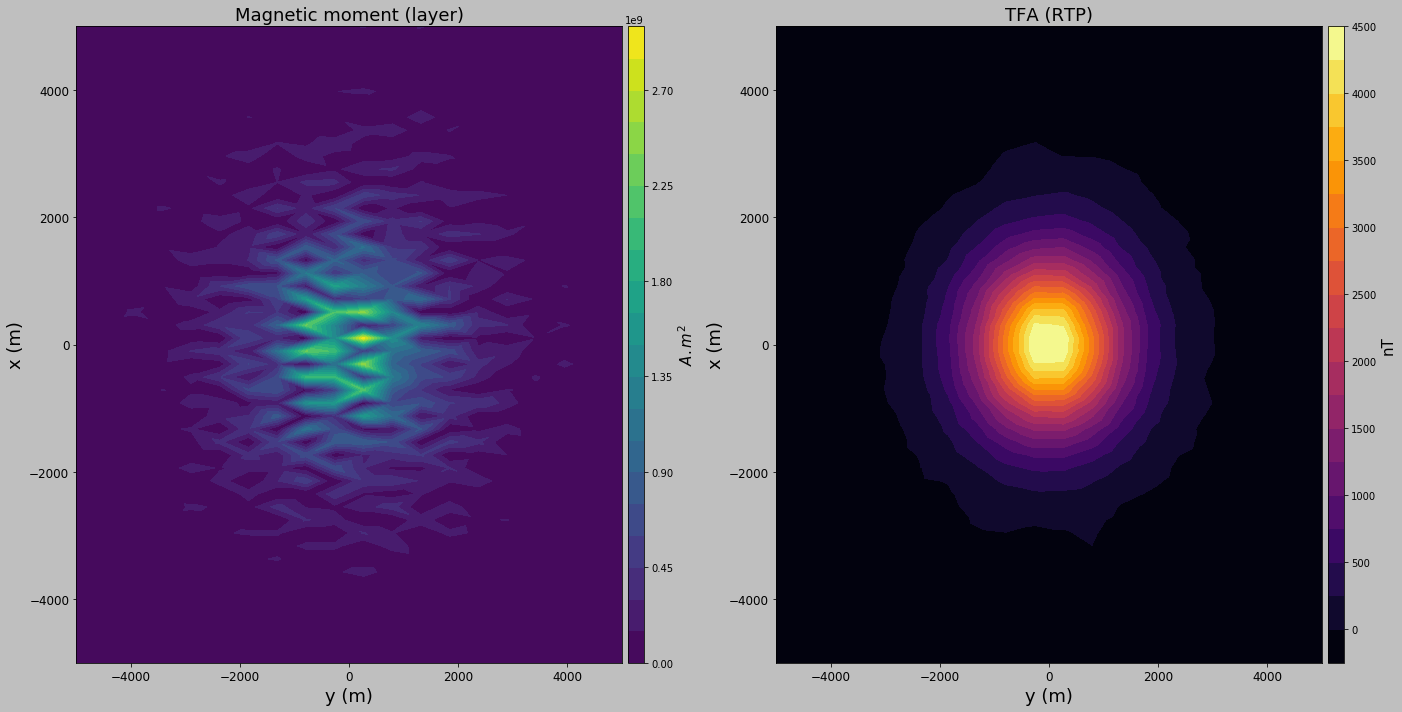

In [50]:
title_font = 18
bottom_font = 15
plt.close('all')
plt.figure(figsize=(20,10), tight_layout=True)

plt.subplot(1,2,1)
plt.tricontourf(ys,xs,m_LM,20,cmap='viridis')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('$A.m^2$',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('Magnetic moment (layer)', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.subplot(1,2,2)
plt.tricontourf(airborne['y'],airborne['x'], tfa_rtp, 20, cmap='inferno')
plt.colorbar(pad=0.01, aspect=40, shrink=1.0).set_label('nT',size=bottom_font)
plt.xlabel('y (m)', fontsize = title_font)
plt.ylabel('x (m)', fontsize = title_font)
plt.title('TFA (RTP)', fontsize=title_font)
plt.tick_params(axis='both', which='major', labelsize=12)

file_name = 'figs/airborne/RTP_moment_LM_NNLS_IM'
plt.savefig(file_name+'.png',dpi=300)
saved_files.append(file_name+'.png')

plt.savefig(file_name+'.eps',dpi=300)
saved_files.append(file_name+'.eps')

plt.show()